# Exploring Training Sample Size vs. Synthetic Data Accuracy

In this exercise, we are going to explore the relationship between the number of training samples, that are being used for the synthesis, and the corresponding accuracy of the generated synthetic data. We expect to see a higher accuracy for an increasing number of training samples. But along with a larger number of training samples, we will also see an increase in computational effort, i.e. overall runtime.

<img src='./size-vs-accuracy.png' width="600px"/>

Note, that we shall not expect synthetic data to perfectly match the original data. This would only be satisfied by a copy of the data, which obviously would neither satisfy any privacy requirements nor would provide any novel samples. That being said, we shall expect that due to sampling variance the synthetic data can deviate. Ideally, just as much, and not more than the deviation that we would observe by analyzing an actual holdout data.

## Synthesize Data via MOSTLY AI

For this tutorial, we will be using the same UCI Adult Income [[1](#refs)] dataset, as well as the same training and validation split, that was used in the Train-Synthetic-Test-Real tutorial. Thus, we have in total 48,842 records across 15 attributes, and will be using up to 39,074 (=80%) of those records for the synthesis.

1. Download `census-training.csv` from [here](./census-training.csv).

2. Synthesize `census-training.csv` via [MOSTLY AI](https://mostly.ai/) multiple times, each time with a different number of maximum training samples. E.g. 100, 400, 1600, 6400, 25600. Always generate a consistent number of subjects, eg. 10000. You can leave all other settings at their default, and just proceed to launch job.

<img src='./screen1.png' width="400px"/> <img src='./screen2.png' width="400px"/>

3. Download the generated datasets from MOSTLY AI as CSV files, and rename each CSV file with an appropriate name (eg. `syn_00100.csv`, `syn_00400.csv`, etc.).

4. Upload all synthetic datasets via executing the next cell.

In [1]:
# upload synthetic dataset
import pandas as pd
try:
    # check whether we are in Google colab
    from google.colab import files
    print("running in COLAB mode")
    import io
    uploaded = files.upload()
    synthetic_datasets = {
      file_name: pd.read_csv(io.BytesIO(uploaded[file_name]), skipinitialspace=True) 
      for file_name in uploaded
    }
except:
    print("running in LOCAL mode")
    print("upload your synthetic data files to this directory via Jupyter")
    from pathlib import Path
    syn_files = sorted(list(Path('.').glob('syn*csv')))
    synthetic_datasets = {
      file_name.name: pd.read_csv(file_name)
      for file_name in syn_files
    }

for k, df in synthetic_datasets.items():
    print(f"Loaded Dataset `{k}` with {df.shape[0]:,} records and {df.shape[1]:,} attributes")

running in LOCAL mode
upload your synthetic data files to this directory via Jupyter
Loaded Dataset `syn_00100.csv` with 10,000 records and 15 attributes
Loaded Dataset `syn_00400.csv` with 10,000 records and 15 attributes
Loaded Dataset `syn_01600.csv` with 10,000 records and 15 attributes
Loaded Dataset `syn_06400.csv` with 10,000 records and 15 attributes
Loaded Dataset `syn_25600.csv` with 10,000 records and 15 attributes


5. Take notes of the reported overall accuracy, as well as the runtime of each job, and update the following DataFrame accordingly.

In [2]:
results = pd.DataFrame([
    {'file': 'syn_00100.csv', 'samples': 100, 'accuracy': 0.830, 'runtime': 42},
    {'file': 'syn_00400.csv', 'samples': 400, 'accuracy': 0.914, 'runtime': 45},
    {'file': 'syn_01600.csv', 'samples': 1600, 'accuracy': 0.956, 'runtime': 48},
    {'file': 'syn_06400.csv', 'samples': 6400, 'accuracy': 0.972, 'runtime': 54},
    {'file': 'syn_25600.csv', 'samples': 25600, 'accuracy': 0.980, 'runtime': 75},
])
results

,file,samples,accuracy,runtime
0,syn_00100.csv,100,0.830,42
1,syn_00400.csv,400,0.914,45
2,syn_01600.csv,1600,0.956,48
3,syn_06400.csv,6400,0.972,54
4,syn_25600.csv,25600,0.980,75


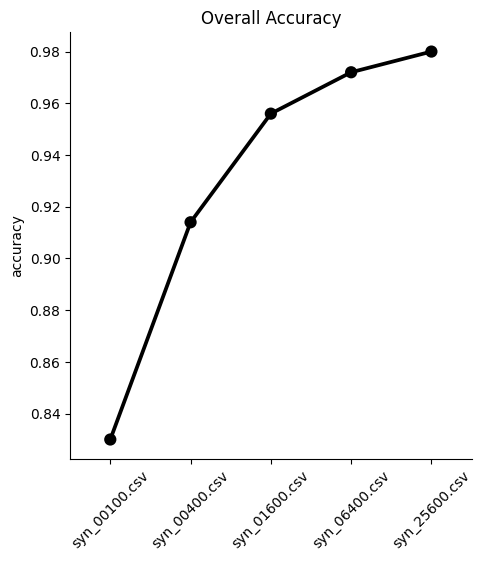

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.catplot(data=results, y='accuracy', x='file', kind='point', color='black')
plt.xticks(rotation=45)
plt.xlabel('')
plt.title('Overall Accuracy')
plt.show()

## Quality Assessment

Concatenate all datasets together to ease comparions across these.

In [4]:
df_trn = pd.read_csv('census-training.csv')
df_hol = pd.read_csv('census-holdout.csv')
dataset = synthetic_datasets | {'target': df_trn, 'holdout': df_hol}
df = pd.concat([d.assign(split=k) for k, d in dataset.items()], axis=0)
# declare `split` column as Categorical and shift to first position
df['split'] = pd.Categorical(df['split'], categories=df["split"].unique())
df.insert(0, 'split', df.pop('split'))
df.groupby('split')['split'].count()

split
syn_00100.csv    10000
syn_00400.csv    10000
syn_01600.csv    10000
syn_06400.csv    10000
syn_25600.csv    10000
target           39074
holdout           9768
Name: split, dtype: int64

### Compare single statistic

#### Share of people from Mexico

In [5]:
stats = df.groupby('split').apply(lambda x: f"{(x['native_country']=='Mexico').mean():.1%} from the Mexico")
stats

split
syn_00100.csv    5.5% from the Mexico
syn_00400.csv    2.3% from the Mexico
syn_01600.csv    2.6% from the Mexico
syn_06400.csv    1.6% from the Mexico
syn_25600.csv    1.8% from the Mexico
target           2.0% from the Mexico
holdout          1.7% from the Mexico
dtype: object

As you can see, and as explained previously, there is also a deviation within statistics between the target and the holdout data. This is expected due to the sampling variance. The smaller the dataset, the larger the sampling variance will be.

#### Average number of Hours-Per-Week, split by Gender

In [6]:
stats = df.groupby(['split', 'sex'])['hours_per_week'].mean().round(1).to_frame().reset_index(drop=False)
stats = stats.pivot_table(index='split', columns=['sex']).reset_index(drop=False)
stats

split hours_per_week      
sex                        Female  Male
0    syn_00100.csv           40.2  42.2
1    syn_00400.csv           39.3  41.0
2    syn_01600.csv           37.0  41.8
3    syn_06400.csv           36.9  41.6
4    syn_25600.csv           36.3  42.6
5           target           36.4  42.4
6          holdout           36.3  42.5

#### Average age, split by education

In [7]:
stats = df.groupby(['split', 'marital_status'])['age'].mean().round().to_frame().reset_index(drop=False)
stats = stats.loc[~stats['marital_status'].isin(['_RARE_', 'Married-AF-spouse', 'Married-spouse-absent', 'Separated'])]
stats = stats.pivot_table(index='split', columns=['marital_status']).reset_index(drop=False)
stats

split      age                                   \
marital_status                Divorced Married-civ-spouse Never-married   
0               syn_00100.csv     42.0               42.0          35.0   
1               syn_00400.csv     42.0               44.0          31.0   
2               syn_01600.csv     42.0               43.0          29.0   
3               syn_06400.csv     43.0               44.0          28.0   
4               syn_25600.csv     44.0               44.0          28.0   
5                      target     43.0               43.0          28.0   
6                     holdout     43.0               44.0          28.0   

                        
marital_status Widowed  
0                  NaN  
1                 45.0  
2                 55.0  
3                 58.0  
4                 60.0  
5                 59.0  
6                 61.0

#### Age distribution, split by income

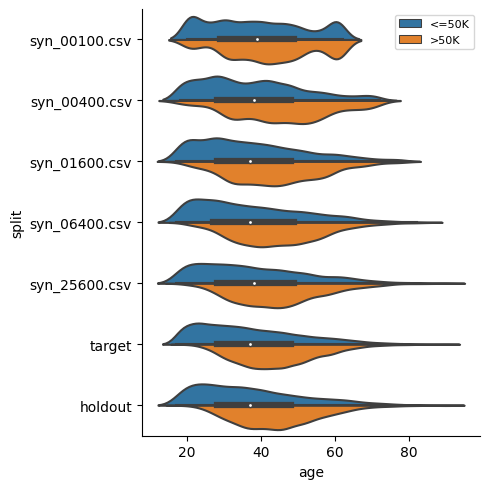

In [8]:
sns.catplot(data=df, x='age', y='split', hue='income', kind='violin', split=True, legend=None)
plt.legend(loc='upper right', title='', prop={'size': 8})
plt.show()

### Check rule adherence

The original data has a 1:1 relationship between `education` and `education_num`. Let's check in how many cases the generated synthetic data has correctly retained that rule.

In [9]:
# convert `education` to Categorical with proper sort order
df['education'] = pd.Categorical(df['education'], categories=df_trn.sort_values('education_num')['education'].unique())
# calculate correct match
stats = df.groupby('split').apply(lambda x: (x['education'].cat.codes+1 == x['education_num']).mean())
stats = stats.to_frame('matches').reset_index()
stats

,split,matches
0,syn_00100.csv,0.5009
1,syn_00400.csv,0.7424
2,syn_01600.csv,0.9149
3,syn_06400.csv,0.9973
4,syn_25600.csv,1.0000
5,target,1.0000
6,holdout,1.0000


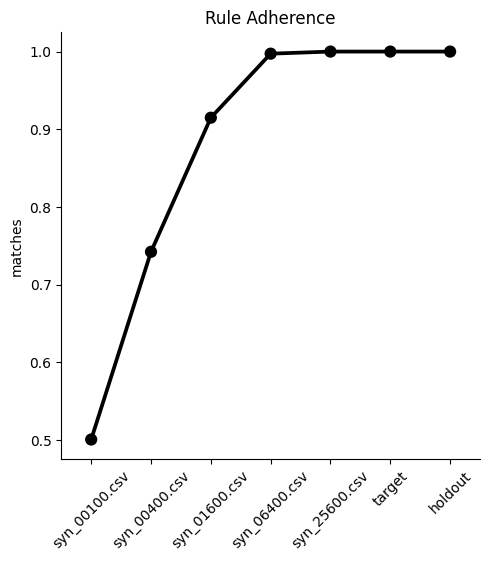

In [10]:
sns.catplot(data=stats, y='matches', x='split', kind='point', color='black')
plt.xticks(rotation=45)
plt.xlabel('')
plt.title('Rule Adherence')
plt.show()

### Compare ML performance

Let's perform a Train-Synthetic-Test-Real evaluation via a downstream LightGBM classifier.

In [11]:
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

target_col = 'income'
target_val = '>50K'

# prepare data, and split into features `X` and target `y`
def prepare_xy(df: pd.DataFrame):
    y = (df[target_col]==target_val).astype(int)
    str_cols = [col for col in df.select_dtypes(['object', 'string']).columns if col != target_col]
    for col in str_cols:
        df[col] = pd.Categorical(df[col])
    cat_cols = [col for col in df.select_dtypes('category').columns if col != target_col]
    num_cols = [col for col in df.select_dtypes('number').columns if col != target_col]
    for col in num_cols:
        df[col] = df[col].astype('float')
    X = df[cat_cols + num_cols]
    return X, y

# train ML model with early stopping
def train_model(X, y):
    cat_cols = list(X.select_dtypes('category').columns)
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    ds_trn = lgb.Dataset(X_trn, label=y_trn, categorical_feature=cat_cols, free_raw_data=False)
    ds_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols, free_raw_data=False)
    model = lgb.train(
        num_boost_round=200,
        params={
            'metric': 'auc',  
            'objective': 'binary'
        }, 
        train_set=ds_trn,
        valid_sets=[ds_val],
        callbacks=[early_stopping(5)],
    )
    return model

# apply ML Model to some holdout data, report key metrics, and visualize scores
def evaluate_model(model, hol):
    X_hol, y_hol = prepare_xy(hol)
    probs = model.predict(X_hol)
    preds = (probs >= 0.5).astype(int)
    auc = roc_auc_score(y_hol, probs)
    return auc

def train_and_evaluate(df):
    X, y = prepare_xy(df)
    model = train_model(X, y)
    auc = evaluate_model(model, df_hol)
    return auc

import warnings
warnings.filterwarnings('ignore')

In [12]:
%%capture
aucs = {k: train_and_evaluate(df) for k, df in dataset.items() if k != 'holdout'}
aucs = pd.Series(aucs).round(3).to_frame('auc').reset_index()

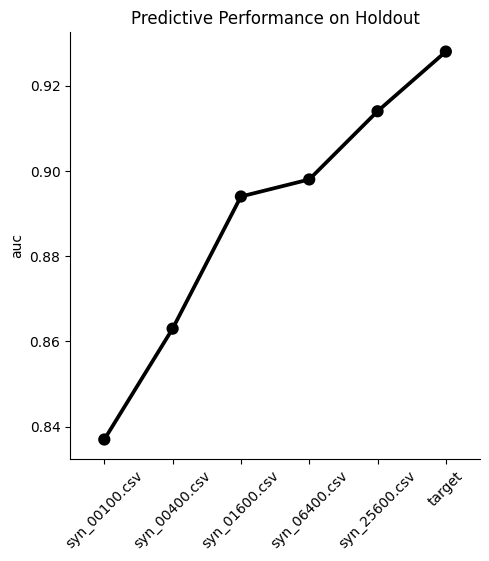

In [13]:
sns.catplot(data=aucs, y='auc', x='index', kind='point', color='black')
plt.xticks(rotation=45)
plt.xlabel('')
plt.title('Predictive Performance on Holdout')
plt.show()

## Conclusion

For the given dataset and the given synthesizer we can indeed observe an increase in synthetic data quality with a growing number of training samples. This can be measured with respect to accuracy, as well as ML utility.

As we can also observe, is that a holdout dataset will exhibit deviations from the training data due to the sampling noise as well. With the holdout data being actual data, that hasn't been seen before, it serves us as a north star in terms of maximum acchievable accuracy for synthetic data. See our paper on this subject [[2](#refs)].

## Further exercises

In addition to walking through the above instructions, we suggest..
* to limit model training to a few epochs, e.g. by setting the maximum number of epochs to 1 or 5 and study its impact on runtime and quality.
* to synthesize with different model_sizes: Small, Medium and Large, and study its impact on runtime and quality.
* to synthesize with the same settings several times, and with that study the variability in quality across several runs.
* to calculate and compare your own statistics, and then compare the deviations between synthetic and training. The deviations between holdout and training can serve as a benchmark .

## References<a class="anchor" name="refs"></a>

1. https://archive.ics.uci.edu/ml/datasets/adult
1. https://www.frontiersin.org/articles/10.3389/fdata.2021.679939/full